In [49]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import array as arr
from numpy import transpose as tr


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual


In [12]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

class ray:
    def __init__(self, x, y, thetax, thetay, w0, sigma=1, z=0, wl=1030, M2=1):
        '''
        Initialise le rayon à une position sur le miroir 1, avec un angle.
        On lui donne son waist au foyer, et la distance entre ce foyer et le miroir (z).
        /!\ : z=0 signifie que le foyer est sur le miroir ! 
        Le waist donné est celui non-linéaire, qu'on espère avoir en fonctionnement optimal de la cellule.
        '''
        self.x = x
        self.y = y
        self.thetax = thetax
        self.thetay = thetay
        self.wavelength = wl
        self.sigma = sigma
        self.M2 = M2
        self.l_arts = []
        # self.q = z + 1j*w0**2 * np.pi/self.wavelength
        self.qnl = z + 1j*w0**2 * np.pi/self.wavelength / np.sqrt(self.sigma)

    def propagation(self, l):
        self.x += l*self.thetax
        self.y += l*self.thetay
        # self.q += l
        self.qnl += l
    
    def mirror(self, Roc):
        self.thetax -= 2*self.x/Roc
        self.thetay -= 2*self.y/Roc
        # self.q = self.q/(1-2/Roc*self.q)
        self.qnl = self.qnl/(1-2/Roc*self.qnl)

    def lens(self, f):
        self.qnl = self.qnl/(1-self.qnl/f)

    def translate_to_polar(self):
        return cart2pol(self.x, self.y)

    def waist0(self):
        return(np.sqrt(np.imag(self.qnl)/np.pi*self.wavelength*np.sqrt(self.sigma)))

    def waist(self):
        return(1/np.sqrt(np.imag(-1/self.qnl) *np.pi/np.sqrt(self.sigma)/self.wavelength))
    
    def pos_waist0(self):
        return(-np.real(self.qnl))


0.266
12.328403154476312
12.326566452151283
11.915667174949073
0.07598593991300016
0.07598593991300016
distance MPC - telescope : 0.690


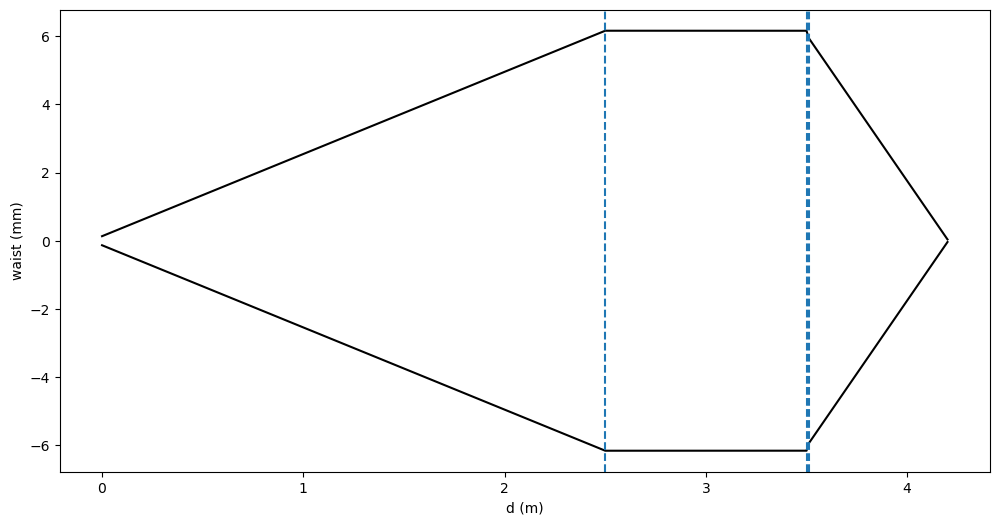

In [36]:
# Schéma : MPC --- l1 --- l2 --- lens --- fiber
#          foc --- DV --- CV ---  CV  ---  foc 

wl = 1030e-9
w0_fiber = 266e-6/2

f_lens = 2.5
f_l1 = -500e-3
f_l2 = +300e-3

d_lens_fiber = 2.5
d_l2_lens = 1000e-3
d_l1_l2 = 10e-3
d_l1_MPC = 0

beam = ray(0, 0, 0, 0, w0=w0_fiber, wl=wl, z=0, M2=1)

beam.propagation(d_lens_fiber)
w_lens = beam.waist()

beam.lens(f_lens)
beam.propagation(d_l2_lens)
w_l2 = beam.waist()

beam.lens(f_l2)
beam.propagation(d_l1_l2)
w_l1 = beam.waist()

beam.lens(f_l1)
w0_MPC = beam.waist0()
d_l1_MPC = beam.pos_waist0()
beam.propagation(d_l1_MPC)
w_MPC = beam.waist()




print(2*w0_fiber*1e3)
print(2*w_lens*1e3)
print(2*w_l2*1e3)
print(2*w_l1*1e3)
print(2*w0_MPC*1e3)
print(2*w_MPC*1e3)


f, ax = plt.subplots(1,1, figsize=(12,6))

l_x = arr([0, d_lens_fiber, d_lens_fiber+d_l2_lens, d_lens_fiber+d_l2_lens+d_l1_l2, d_lens_fiber+d_l2_lens+d_l1_l2+d_l1_MPC])
l_y = arr([w0_fiber, w_lens, w_l2, w_l1, w_MPC])

ax.plot(l_x, +l_y*1e3, '-k')
ax.plot(l_x, -l_y*1e3, '-k')
ax.axvline(x=d_lens_fiber, linestyle='--')
ax.axvline(x=d_lens_fiber+d_l2_lens, linestyle='--')
ax.axvline(x=d_lens_fiber+d_l2_lens+d_l1_l2, linestyle='--')

ax.set_ylabel('waist (mm)')
ax.set_xlabel('d (m)')
print(f'distance MPC - telescope : {d_l1_MPC:.3f}')

In [66]:
slider_f_lens =          widgets.IntSlider(min=0, max=3000, step=50, value=2500, continuous_update=False)
slider_f_l1 =            widgets.IntSlider(min=-1000, max=1000, step=50, value=+500, continuous_update=False)
slider_f_l2 =            widgets.IntSlider(min=-1000, max=1000, step=50, value=-500, continuous_update=False)

slider_d_lens_fiber = widgets.IntSlider(min=0, max=10000, value=2500, step=50, continuous_update=False)
slider_d_l2_lens = widgets.IntSlider(min=0, max=10000, value=1000, step=50, continuous_update=False)
slider_d_l1_l2 = widgets.IntSlider(min=0, max=10000, value=80, step=50, continuous_update=False)




# f, ax = plt.subplots(1,1, figsize=(12,6))


def setup_lenses(f_lens=slider_f_lens, f_l1=slider_f_l1, f_l2=slider_f_l2, d_lens_fiber=slider_d_lens_fiber, d_l2_lens=slider_d_l2_lens, d_l1_l2=slider_d_l1_l2):
    f_lens *= 1e-3
    f_l1 *= 1e-3
    f_l2 *= 1e-3
    d_lens_fiber *= 1e-3
    d_l2_lens *= 1e-3
    d_l1_l2 *= 1e-3
    beam = ray(0, 0, 0, 0, w0=w0_fiber, wl=wl, z=0, M2=1)

    beam.propagation(d_lens_fiber)
    w_lens = beam.waist()

    beam.lens(f_lens)
    beam.propagation(d_l2_lens)
    w_l2 = beam.waist()

    beam.lens(f_l2)
    beam.propagation(d_l1_l2)
    w_l1 = beam.waist()

    beam.lens(f_l1)
    w0_MPC = beam.waist0()
    d_l1_MPC = beam.pos_waist0()
    beam.propagation(d_l1_MPC)
    w_MPC = beam.waist()




    print(2*w0_fiber*1e3)
    print(2*w_lens*1e3)
    print(2*w_l2*1e3)
    print(2*w_l1*1e3)
    print(2*w0_MPC*1e3)
    print(2*w_MPC*1e3)



    l_x = arr([0, d_lens_fiber, d_lens_fiber+d_l2_lens, d_lens_fiber+d_l2_lens+d_l1_l2, d_lens_fiber+d_l2_lens+d_l1_l2+d_l1_MPC])
    l_y = arr([w0_fiber, w_lens, w_l2, w_l1, w_MPC])

    graph.clear_output(wait=False)
    with graph:
        f, ax = plt.subplots(1,1, figsize=(12,6))
        ax.clear()
        ax.plot(l_x, +l_y*1e3, '-k')
        ax.plot(l_x, -l_y*1e3, '-k')
        ax.axvline(x=d_lens_fiber, linestyle='--')
        ax.axvline(x=d_lens_fiber+d_l2_lens, linestyle='--')
        ax.axvline(x=d_lens_fiber+d_l2_lens+d_l1_l2, linestyle='--')

        ax.set_ylabel('waist (mm)')
        ax.set_xlabel('d (m)')
        print(f'waist MPC : {2*w_MPC*1e3}')
        print(f'distance MPC - telescope : {d_l1_MPC:.3f}')
        plt.show()
    return()



out = widgets.interactive_output(setup_lenses, {'f_lens':slider_f_lens, 'f_l1':slider_f_l1, 'f_l2':slider_f_l2, 
                                       'd_lens_fiber':slider_d_lens_fiber, 'd_l2_lens':slider_d_l2_lens, 'd_l1_l2':slider_d_l1_l2})

names_ui1 = ['f_lens : ', 'f_l1 : ', 'f_l2 : ']
names_ui2 = ['d_lens_fiber : ', 'd_l2_lens : ', 'd_l1_l2 : ']
w_lbl_1 = widgets.VBox([widgets.Label(title) for title in names_ui1])
w_lbl_2 = widgets.VBox([widgets.Label(title) for title in names_ui2])
ui1 = widgets.VBox([slider_f_lens, slider_f_l1, slider_f_l2])
ui2 = widgets.VBox([slider_d_lens_fiber, slider_d_l2_lens, slider_d_l1_l2])
ui_sl = widgets.HBox([w_lbl_1, ui1, w_lbl_2, ui2])

graph = widgets.Output(layout={'border': '1px solid black'})

ui = widgets.VBox([ui_sl, graph])
display(ui)
# display(graph)